# Import Libraries

In [1]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime as dt
import math

import pickle
import joblib
%matplotlib inline

In [2]:
BNB_RED = '#FF5A5F'

# Load the Data

In [3]:
listings_df = pd.read_csv('/users/luyuankong/Downloads/data/listings.csv')

In [4]:
print(f'column names for listing: \n {listings_df.columns.values}')
print(f'number of featurers in the listing: \n {len(listings_df.columns.values)}')

column names for listing: 
 ['id' 'name' 'host_id' 'host_name' 'neighbourhood_group' 'neighbourhood'
 'latitude' 'longitude' 'room_type' 'price' 'minimum_nights'
 'number_of_reviews' 'last_review' 'reviews_per_month'
 'calculated_host_listings_count' 'availability_365']
number of featurers in the listing: 
 16


In [5]:
listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.39,2,365
1,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,307,2020-02-08,4.69,1,137
2,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.59,1,0
3,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,29,50,2019-12-02,0.38,1,365
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,463,2020-01-28,3.53,1,216


In [6]:
listings_detail_df = pd.read_csv('/users/luyuankong/Downloads/data/listings_detail.csv')

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(f'column names for detailed listing: \n {listings_detail_df.columns.values}')
print(f'number of featurers in the detailed listing: \n {len(listings_detail_df.columns.values)}')

column names for detailed listing: 
 ['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_dep

In [8]:
listings_detail_df.shape

(51097, 106)

In [9]:
listings_df.shape

(51097, 16)

# merge two dfs with same listing id column

In [10]:

nyc_df  = listings_df.merge(listings_detail_df, on = 'id', how = 'right')

## drop overlap features

In [11]:
overlap_to_drop = ['name_y', 'host_id_y', 'host_name_y',
       'neighbourhood_y', 'latitude_y', 'longitude_y', 'room_type_y',
       'price_y', 'minimum_nights_y', 'number_of_reviews_y',
       'last_review_y', 'reviews_per_month_y',
       'calculated_host_listings_count_y', 'availability_365_y']

In [12]:
nyc_df.drop(columns=overlap_to_drop, inplace=True)

In [13]:
nyc_df.rename(columns=lambda name: name.replace("_x", ""), inplace=True)

In [14]:
# we want to predict prices based on listings show good reviews on their pricing strategy
# so we select # reviews > 0 and review_score > 6 out of 10

nyc_df = nyc_df[nyc_df.number_of_reviews > 0 ]
nyc_df = nyc_df[nyc_df.review_scores_value > 5.0]
nyc_df = nyc_df[nyc_df.price > 0]

In [15]:
text_features = ['id','host_name','name','summary','space','description','neighborhood_overview','house_rules','price','host_name']
df_text = nyc_df[text_features]

# #Save for later
# with open('Downloads/data/df_text.pickle', 'wb') as to_write:
#     pickle.dump(df_text, to_write)

In [16]:
# drop the text features
nyc_df.drop(columns=['host_name','name','summary','space','description',
                                 'neighborhood_overview','house_rules'], inplace=True)

## drop irrelevent features

In [17]:
nyc_df.isna().sum().sort_values(ascending=False)[0:30]


xl_picture_url                 39427
medium_url                     39427
thumbnail_url                  39427
jurisdiction_names             39417
license                        39411
square_feet                    39083
monthly_price                  35209
weekly_price                   34725
notes                          21652
access                         15962
host_about                     14369
interaction                    13819
host_response_rate             12291
host_response_time             12291
security_deposit               11425
transit                        11271
host_acceptance_rate            8082
cleaning_fee                    5906
host_neighbourhood              5075
zipcode                          349
city                             112
host_location                     88
beds                              86
market                            74
bedrooms                          43
bathrooms                         33
review_scores_accuracy             8
s

In [18]:
nyc_df.shape

(39427, 100)

In [19]:
nyc_df.columns.values

array(['id', 'host_id', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'listing_url', 'scrape_id', 'last_scraped', 'experiences_offered',
       'notes', 'transit', 'access', 'interaction', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country',
 

In [20]:
features_to_drop = ['number_of_reviews', 'host_id', 'neighbourhood_group','latitude', 'longitude', 
       'last_review','reviews_per_month','listing_url', 'scrape_id', 'last_scraped', 'experiences_offered',
       'notes', 'transit', 'access', 'interaction', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url',
       'host_location', 'host_about','host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count','host_verifications',
       'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country',
       'is_location_exact','is_location_exact','beds','square_feet',
       'weekly_price', 'monthly_price', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'license',
       'jurisdiction_names', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
       'is_business_travel_ready','require_guest_profile_picture','require_guest_phone_verification'
]

In [21]:
nyc_df.drop(columns=features_to_drop, inplace=True)

In [22]:
nyc_df.dtypes

id                                  int64
neighbourhood                      object
room_type                          object
price                               int64
minimum_nights                      int64
calculated_host_listings_count      int64
availability_365                    int64
host_since                         object
host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_has_profile_pic               object
host_identity_verified             object
property_type                      object
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
bed_type                           object
amenities                          object
security_deposit                   object
cleaning_fee                       object
guests_included                     int64
extra_people                      

# Data Cleaning & Feature Engineering

## Helper Function

In [23]:
def clean_t(val):
    """
    return 1 if ture 0 if false
    """
    if (val == 't'):
        return 1
    else:
        return 0

In [24]:
def clean_nan(num):
    """
    get rid of nan value, if it's not nan return the original value
    """
    if (math.isnan(num)):
        return 0
    else:
        return num

In [25]:
def clean_price_sign(price):
    '''
    clean and help the missing number on security_deposit, cleaning_fee
    '''
    if type(price) == str:
        return float(price.replace('$','').replace(',',''))
    else:
        return 0

In [26]:
def clean_percent_sign(val):
    '''
    clean % sign and if val is nan returns 0
    '''
    if type(val) == str:
        return float(val.replace('%',''))
    else:
        return 0

## Numerical Features

num_fea: 
           'minimum_nights',
           'calculated_host_listings_count',
           'availability_365','host_since',
           'bathrooms','bedrooms','guests_included','accommodates',
           'host_acceptance_rate','host_response_rate',
           'security_deposit','cleaning_fee','extra_people'

In [27]:
# security deposite & cleaning_fee & extra_people

nyc_df.security_deposit = nyc_df['security_deposit'].apply(lambda x: clean_price_sign(x))
nyc_df.cleaning_fee = nyc_df['cleaning_fee'].apply(lambda x: clean_price_sign(x))
nyc_df.extra_people = nyc_df['extra_people'].apply(lambda x: clean_price_sign(x))

In [28]:
# bathrooms

nyc_df.bathrooms = nyc_df['bathrooms'].apply(lambda x: clean_nan(x))

In [29]:
# host_response_rate & host_acceptance_rate

for i in ['host_acceptance_rate','host_response_rate']:
    nyc_df[i] = nyc_df[i].apply(lambda x: clean_percent_sign(x))

In [30]:
#host_since

nyc_df.host_since = pd.to_datetime(
    nyc_df.host_since)

In [31]:
nyc_df['host_since'] = [(dt.datetime.today() - x).days for x in nyc_df.host_since]

In [32]:
nyc_df.host_since = nyc_df['host_since'].apply(lambda x: clean_nan(x))

In [33]:
nyc_df.bedrooms = nyc_df['bedrooms'].apply(lambda x: clean_nan(x))

In [34]:
nyc_df.isna().sum().sort_values(ascending=False)[0:30]

host_response_time                12291
host_has_profile_pic                  2
host_is_superhost                     2
host_identity_verified                2
neighbourhood                         0
room_type                             0
price                                 0
minimum_nights                        0
calculated_host_listings_count        0
availability_365                      0
host_since                            0
host_response_rate                    0
host_acceptance_rate                  0
cancellation_policy                   0
instant_bookable                      0
property_type                         0
accommodates                          0
bathrooms                             0
bedrooms                              0
bed_type                              0
amenities                             0
security_deposit                      0
cleaning_fee                          0
guests_included                       0
extra_people                          0


## Categorical features:

cat_fea = 'host_is_superhost','instant_bookable','host_has_profile_pic','host_identity_verified',
           'neighbourhoods','host_response_time','bed_type','room_type', 'property_type'


In [35]:
del nyc_df['host_response_time'] # might come back later to deal with so many missing values


In [36]:
for col in ['host_is_superhost','instant_bookable',
            'host_has_profile_pic','host_identity_verified']:
    nyc_df[col] = nyc_df[col].apply(lambda x: clean_t(x))
    

In [37]:
# Neighbourhood

nyc_df.neighbourhood.fillna('Other',inplace=True)


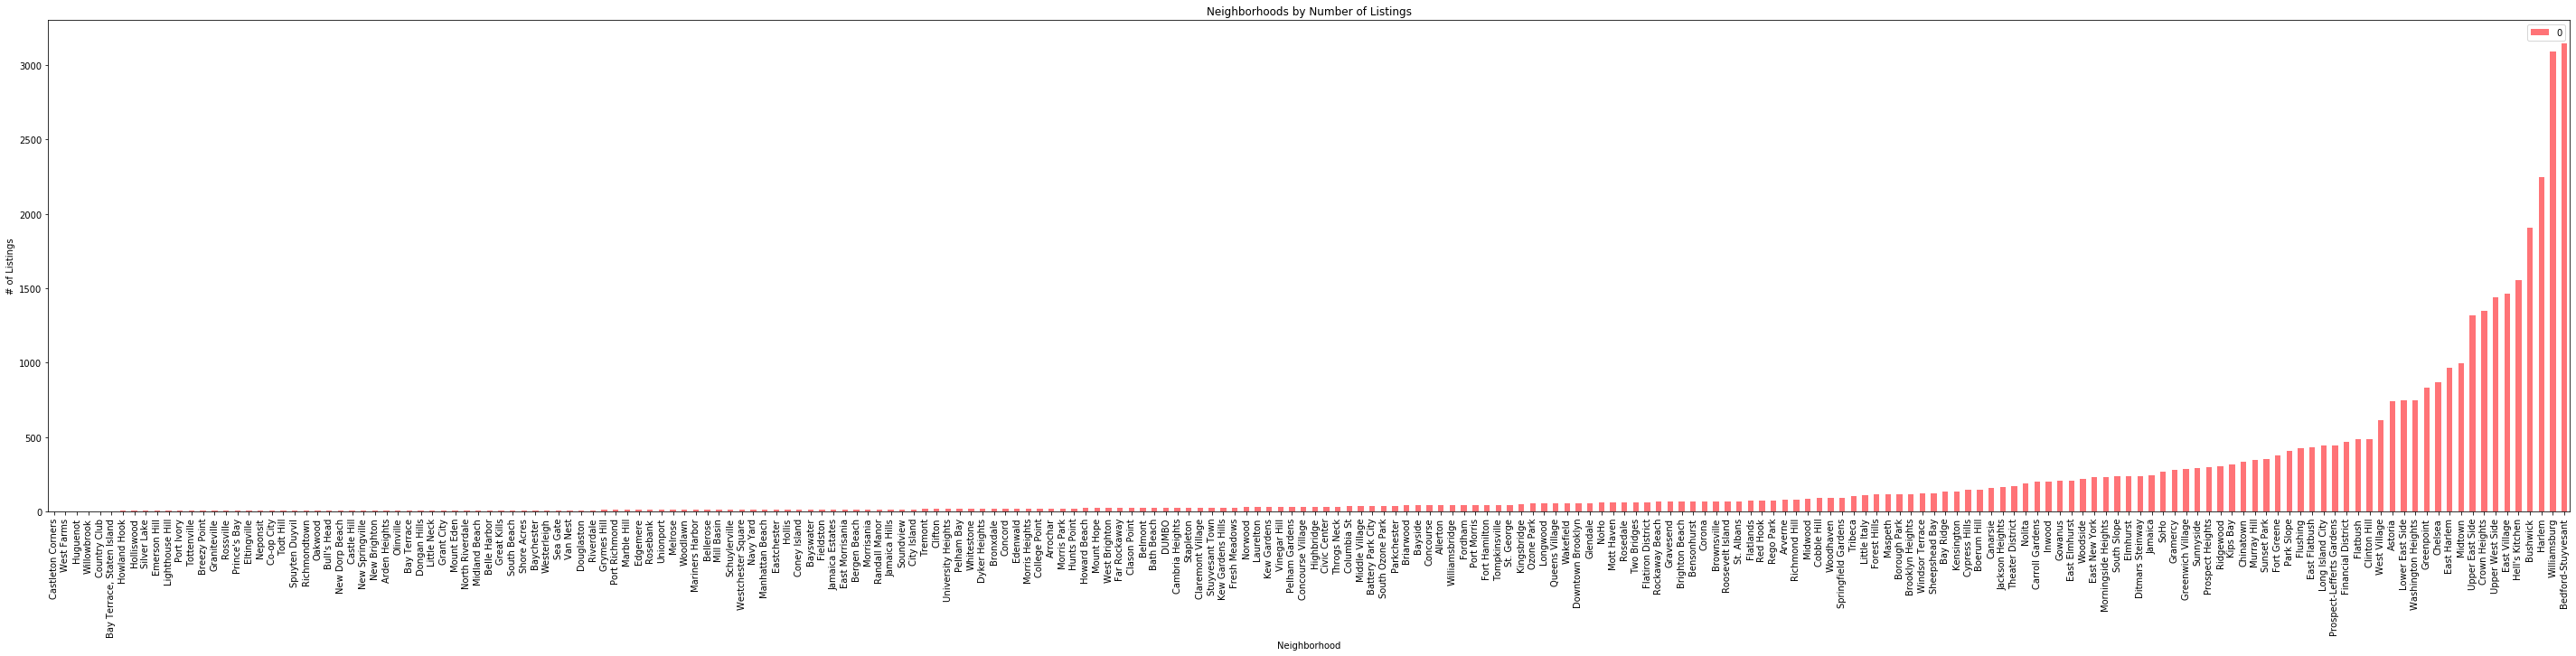

Number of Neighborhoods: 220


In [38]:
# Get number of listings in neighborhoods
nb_counts = Counter(nyc_df.neighbourhood)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)

# Plot number of listings in each neighborhood
ax = tdf.plot(kind='bar', figsize = (50,10), color = BNB_RED, alpha = 0.85)
ax.set_title("Neighborhoods by Number of Listings")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("# of Listings")
plt.show()

print("Number of Neighborhoods:", len(nb_counts))

We see that the majority of the neighborhoods have less than 500 listings. We currently have 220 neighborhoods - all of these categorical predictors when one-hot encoded will weaken predictive power, so we will only keep neighborhoods with more than 500 listings.

In [39]:
# Put listings with less than 500 listings into an "Other" column
top_neighbourhoods = nyc_df.groupby('neighbourhood').size() > 500

nyc_df[
    'neighbourhoods'] = nyc_df.neighbourhood.apply(
        lambda x: x if top_neighbourhoods[x] else 'Other')

In [40]:
nyc_df.neighbourhoods.value_counts()

Other                 15404
Bedford-Stuyvesant     3146
Williamsburg           3092
Harlem                 2250
Bushwick               1905
Hell's Kitchen         1553
East Village           1466
Upper West Side        1439
Crown Heights          1345
Upper East Side        1318
Midtown                 995
East Harlem             967
Chelsea                 868
Greenpoint              830
Lower East Side         748
Washington Heights      748
Astoria                 741
West Village            612
Name: neighbourhoods, dtype: int64

In [41]:
nyc_df.columns.values

array(['id', 'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'calculated_host_listings_count', 'availability_365', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'property_type',
       'accommodates', 'bathrooms', 'bedrooms', 'bed_type', 'amenities',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'instant_bookable', 'cancellation_policy',
       'neighbourhoods'], dtype=object)

In [42]:
nyc_df.describe()

,id,price,minimum_nights,calculated_host_listings_count,availability_365,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,security_deposit,cleaning_fee,guests_included,extra_people,instant_bookable
count,3.942700e+04,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000,39427.000000
mean,2.114950e+07,148.514140,6.008167,5.445355,119.307556,1742.117153,65.117229,66.639536,0.243615,0.997590,0.476044,2.917037,1.135542,1.183554,176.804043,55.039136,1.596495,16.139321,0.379131
std,1.258221e+07,311.613914,18.185810,25.253764,132.638199,901.067885,45.653809,39.850733,0.429268,0.049028,0.499432,1.904665,0.406510,0.752726,411.681379,55.131403,1.224171,25.090165,0.485177
min,2.595000e+03,10.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,9.916878e+06,68.000000,1.000000,1.000000,0.000000,1057.000000,0.000000,33.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,15.000000,1.000000,0.000000,0.000000
50%,2.130758e+07,100.000000,2.000000,1.000000,67.000000,1758.000000,100.000000,89.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,45.000000,1.000000,10.000000,0.000000
75%,3.237925e+07,170.000000,4.000000,2.000000,231.000000,2414.000000,100.000000,99.000000,0.000000,1.000000,1.000000,4.000000,1.000000,1.000000,200.000000,80.000000,2.000000,25.000000,1.000000
max,4.215487e+07,10000.000000,1250.000000,293.000000,365.000000,4227.000000,100.000000,100.000000,1.000000,1.000000,1.000000,22.000000,15.500000,21.000000,5100.000000,1000.000000,16.000000,300.000000,1.000000


In [43]:
# amenities

In [44]:
amenities_set = set()

def collect_amenities(entry):
    entry_list = entry.replace("{", "").replace("}", "").replace("'", "").replace('"', "").replace(" ", "_").split(',')
    for am in entry_list:
        if ('translation_missing' not in am and am != ''):
            amenities_set.add(am)

nyc_df['amenities'].apply(collect_amenities)

def generic_amenities(entry, amenity):
    entry_list = entry.replace("{", "").replace("}", "").replace("'", "").replace('"', "").replace(" ", "_").split(',')
    for am in entry_list:
        if (am == amenity):
            return 1
    return 0

for amenity in amenities_set:
    nyc_df.insert(len(list(nyc_df)), amenity, 0)
    nyc_df[amenity] = nyc_df['amenities'].apply(lambda x: generic_amenities(x, amenity))

In [45]:
nyc_df.property_type.value_counts()

Apartment                 30591
House                      3457
Townhouse                  1482
Condominium                1301
Loft                       1182
Guest suite                 396
Serviced apartment          230
Boutique hotel              229
Hotel                       157
Other                        63
Guesthouse                   61
Hostel                       52
Bed and breakfast            43
Resort                       43
Bungalow                     29
Villa                        23
Tiny house                   18
Camper/RV                    18
Cottage                       8
Earth house                   7
Aparthotel                    7
Boat                          7
Tent                          5
Barn                          3
Houseboat                     3
Cave                          2
Casa particular (Cuba)        2
Cabin                         2
Dome house                    1
Island                        1
Treehouse                     1
Castle  

In [46]:
# property_type

# Put listings with less than 280 listings into an "Other" column
top_proper = nyc_df.groupby('property_type').size() > 280

nyc_df[
    'property_type'] = nyc_df.property_type.apply(
        lambda x: x if top_proper[x] else 'Other')


In [47]:
nyc_df.property_type.value_counts() 

# drop 'Other' later

Apartment      30591
House           3457
Townhouse       1482
Condominium     1301
Loft            1182
Other           1018
Guest suite      396
Name: property_type, dtype: int64

In [48]:
nyc_df.room_type.value_counts() # drop 'Hotel room' later

Entire home/apt    20776
Private room       17525
Shared room          862
Hotel room           264
Name: room_type, dtype: int64

In [49]:
nyc_df.bed_type.value_counts() 

Real Bed         38836
Futon              225
Pull-out Sofa      204
Airbed             113
Couch               49
Name: bed_type, dtype: int64

In [50]:
nyc_df.cancellation_policy.value_counts() 

strict_14_with_grace_period    19861
moderate                       10337
flexible                        9181
super_strict_30                   21
strict                            17
super_strict_60                   10
Name: cancellation_policy, dtype: int64

In [51]:
#drop couch, drop Hotel room, drop, 

for col_name in ['neighbourhoods', 'bed_type',
                 'room_type', 'property_type','cancellation_policy']:
    parsed_cols = pd.get_dummies(nyc_df[col_name])
    nyc_df = nyc_df.drop(columns=[col_name])
    nyc_df = pd.concat([nyc_df, parsed_cols], axis = 1)

### drop all first columns

In [52]:
del nyc_df['amenities']

In [53]:
del nyc_df['neighbourhood']

# drop 'Other' later

In [54]:
del nyc_df['Other']

In [55]:
del nyc_df['Couch']

In [56]:
del nyc_df['Hotel room']

In [57]:
for col in [['strict','super_strict_30','super_strict_60']]:
    nyc_df.drop(columns=col, inplace=True)

## Target Transform

Text(0.5, 0, 'log(price)')

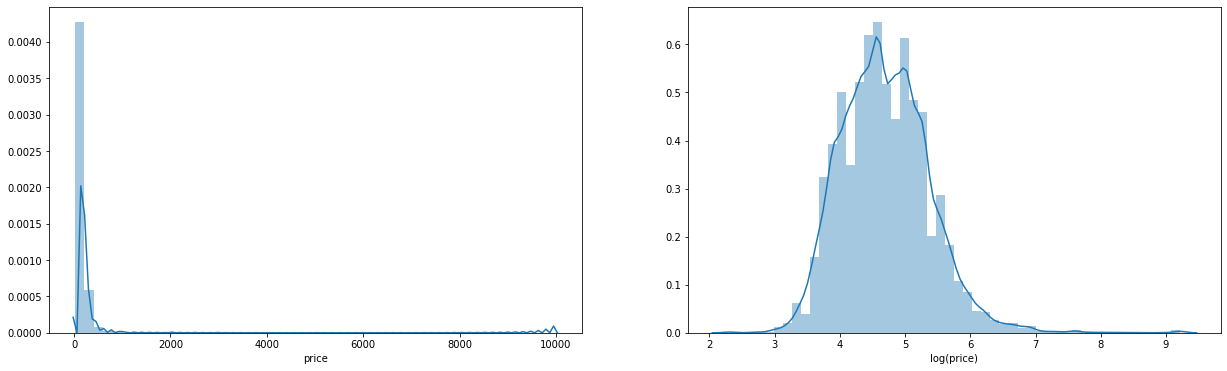

In [58]:
# take a look at the original distribution of price & distribution after log transform

fig, axes = plt.subplots(1,2, figsize=(21,6))
sns.distplot(nyc_df['price'], ax=axes[0])
sns.distplot(np.log(nyc_df['price']), ax=axes[1])
axes[1].set_xlabel('log(price)')

In [ ]:
# with open('Downloads/data/nyc_df5.pickle', 'wb') as to_write:
#     pickle.dump(nyc_df, to_write)

## Outliers

In [79]:
nyc_df = nyc_df[nyc_df.bedrooms < 8]

In [82]:
def show_outliers(col_name):
    q1 = nyc_df[col_name].quantile(.25)
    q3 = nyc_df[col_name].quantile(.75)
    iqr = q3 - q1

    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    quartile_mask = nyc_df[col_name].between(lower_bound, upper_bound, inclusive=True)
    allowed_idx = nyc_df.loc[quartile_mask, col_name].index
    print(nyc_df[nyc_df.index.isin(allowed_idx)].shape[0]/nyc_df.shape[0])

In [83]:
remove_outliers('price')

0.9465404815669957


In [84]:
nyc_df['log_price'] = np.log(nyc_df.price)

/Users/luyuankong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [86]:
# with open('/users/luyuankong/downloads/data/nyc_df5.pickle', 'wb') as to_write:
#     pickle.dump(nyc_df, to_write)